In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
from sgtaxidata import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from matplotlib import cm

DBNAME="../taxis.db"
LAT=1.380766
LON=103.891675
LAT1=1.303693
LON1=103.844952

holidays=['20170626']
def peak(h,m,w):
    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0


In [2]:
dates=taxis.get_dates(DBNAME)
dates=[str(x[0]) for x in dates]
dates

['20170624',
 '20170625',
 '20170626',
 '20170627',
 '20170628',
 '20170629',
 '20170630',
 '20170701',
 '20170702',
 '20170703',
 '20170704',
 '20170705',
 '20170706',
 '20170707',
 '20170708']

In [3]:
df=taxis.get_df_all_taxi_data_loc(DBNAME,LAT,LON)
df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)


In [4]:
df.tail()

,Point,Date,Time,X,Y,TaxiCount,Hour,Minute,Weekday,Holiday,PeakHour
4119,4119,20170708,2330,24,12,19,23,30,0,0,1
4120,4120,20170708,2335,24,12,23,23,35,0,0,1
4121,4121,20170708,2340,24,12,16,23,40,0,0,1
4122,4122,20170708,2345,24,12,21,23,45,0,0,1
4123,4123,20170708,2350,24,12,17,23,50,0,0,1


In [5]:
h=df.quantile(q=0.8)['TaxiCount']
l=df.quantile(q=0.2)['TaxiCount']

[[ 24.          12.          32.375     ]
 [ 24.          12.          19.92      ]
 [ 24.          12.          41.71794872]
 [ 24.          12.          26.06521739]
 [ 24.          12.          17.44      ]
 [ 24.          12.          28.97619048]
 [ 24.          12.          36.75609756]
 [ 24.          12.          22.85714286]]


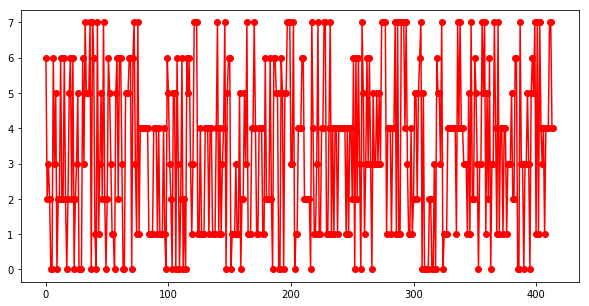

In [6]:
df_sub=df.query('(TaxiCount>=@l and TaxiCount<=@h) and (Hour>=6 and Hour<=12) and Weekday==1')[['X','Y','Hour','Minute','PeakHour','TaxiCount']]
df_sub.head()

X=df_sub.drop(['Hour','Minute','PeakHour'],axis=1).as_matrix()

km = KMeans()
km.fit(X)

print km.cluster_centers_

plt.plot(km.predict(X),'-ro')
plt.show()

In [7]:
df_sub=df.query('(TaxiCount>=@l and TaxiCount<=@h) and (Hour>=6 and Hour<=12) and Weekday==1')[['Hour','Minute','PeakHour','TaxiCount']]
df_sub.head()

,Hour,Minute,PeakHour,TaxiCount
531,6,5,1,37
532,6,10,1,42
533,6,15,1,27
534,6,20,1,41
535,6,25,1,33


In [8]:
f=df_sub['Hour'].count()
c=int(f*0.8)
d=f-c
print c
print d
training=df_sub.head(c)
testing=df_sub.tail(d)

332
83


KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=2, kernel='rbf',
      kernel_params=None)
0.520408542732


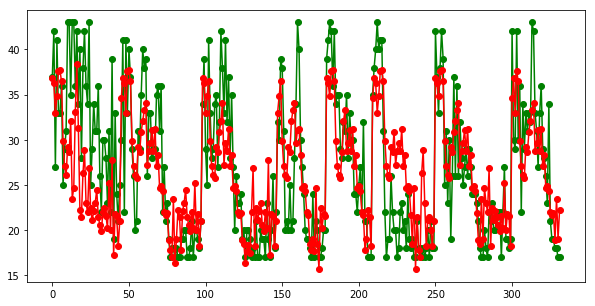

In [9]:
X=training.drop(['TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

kr=KernelRidge(alpha=0.1,kernel='rbf',gamma=2).fit(X,y)
print kr

print kr.score(X,y)

plt.plot(y,'-go')
plt.plot(kr.predict(X),'-ro')
plt.show()


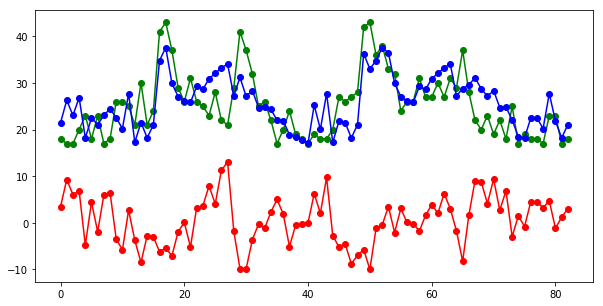

In [10]:
Xt=testing.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=kr.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

plt.plot(yt,'-go')
plt.plot(P,'-bo')
plt.plot(e,'-ro')
plt.show()

/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=5, oob_score=True, random_state=None,
           verbose=0, warm_start=False)
0.518558171538
[ 0.6914216   0.28600257  0.02257582]
1


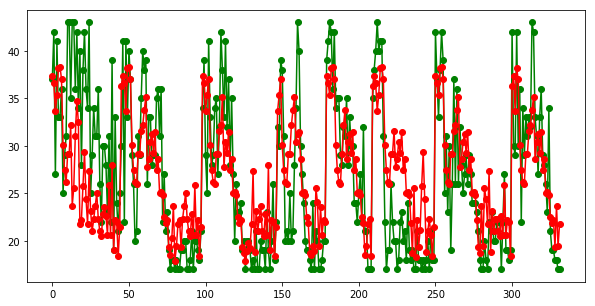

In [11]:
X=training.drop(['TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

rf=RandomForestRegressor(n_estimators=100,criterion='mse',oob_score=True,n_jobs=5).fit(X,y)
print rf

print rf.score(X,y)
print rf.feature_importances_
print rf.n_outputs_

plt.plot(y,'-go')
plt.plot(rf.predict(X),'-ro')
plt.show()


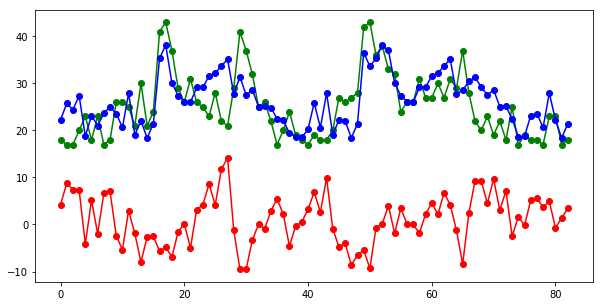

In [12]:
Xt=testing.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=rf.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

plt.plot(yt,'-go')
plt.plot(P,'-bo')
plt.plot(e,'-ro')
plt.show()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')
0.511595493283


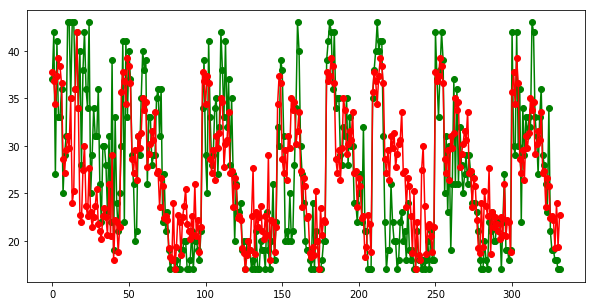

In [13]:
X=training.drop(['TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

kn=KNeighborsRegressor(weights='distance').fit(X,y)

print kn

print kn.score(X,y)


plt.plot(y,'-go')
plt.plot(kn.predict(X),'-ro')
plt.show()

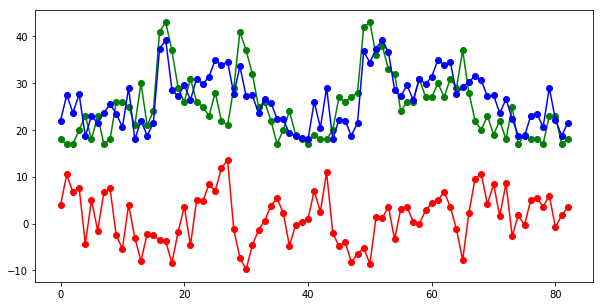

In [14]:
Xt=testing.drop(['TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=kn.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

plt.plot(yt,'-go')
plt.plot(P,'-bo')
plt.plot(e,'-ro')
plt.show()